In [8]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
!pip install pyEDFlib

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
    --------------------------------------- 0.0/2.2 MB 660.6 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.2 MB 919.0 kB/s eta 0:00:03
   ------ --------------------------------- 0.4/2.2 MB 2.9 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.2 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 10.8 MB/s eta 0:00:00


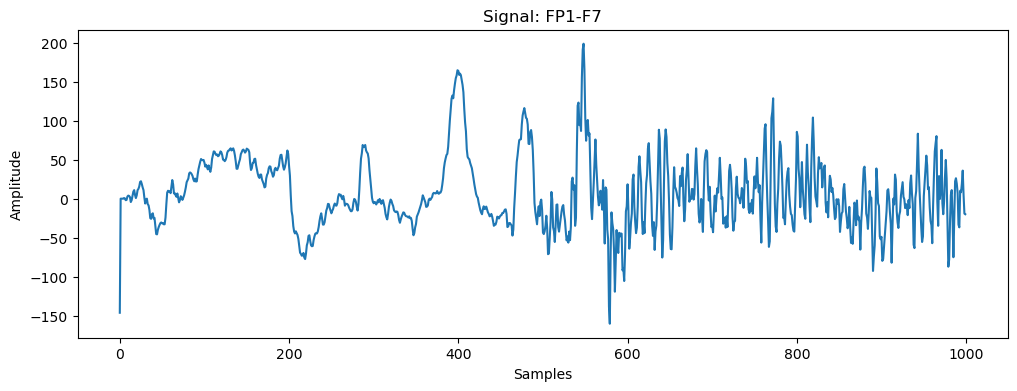

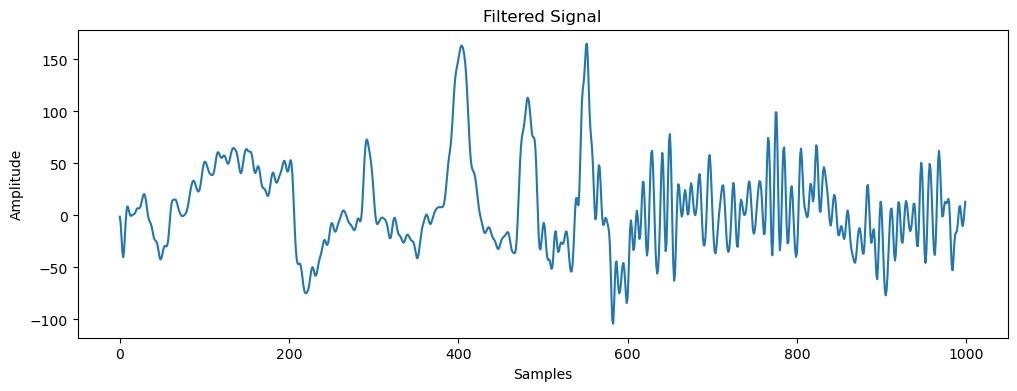

In [25]:
# Import necessary libraries
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Load the CHB-MIT EEG dataset file
file_path = "chb01_01.edf"

# Read the EDF file
edf_reader = pyedflib.EdfReader(file_path)
n_signals = edf_reader.signals_in_file
signal_labels = edf_reader.getSignalLabels()
sampling_rate = edf_reader.getSampleFrequencies()

# Extract signals
signals = np.zeros((n_signals, edf_reader.getNSamples()[0]))
for i in range(n_signals):
    signals[i, :] = edf_reader.readSignal(i)

edf_reader._close()

# Visualize a signal
plt.figure(figsize=(12, 4))
plt.plot(signals[0, :1000])  # Plot first 1000 samples of the first channel
plt.title(f"Signal: {signal_labels[0]}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# Apply noise reduction (e.g., low-pass filtering)
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    y = lfilter(b, a, data)
    return y

filtered_signal = butter_lowpass_filter(signals[0, :], cutoff=30, fs=sampling_rate[0], order=4)

plt.figure(figsize=(12, 4))
plt.plot(filtered_signal[:1000])  # Plot filtered signal
plt.title("Filtered Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [26]:
# Extract features using simple statistical measures
def extract_features(signal):
    return [
        np.mean(signal),  # Mean
        np.std(signal),  # Standard Deviation
        np.min(signal),  # Minimum
        np.max(signal),  # Maximum
        np.median(signal),  # Median
    ]

features = extract_features(filtered_signal)
print("Extracted Features:", features)


Extracted Features: [0.26393129392245573, 69.10660586401144, -663.393669158287, 922.3949652616268, -1.5725258838025356]


In [27]:
from sklearn.model_selection import train_test_split

# Example: Create dummy labels (1 for seizure, 0 for normal)
# Replace this with actual labels from the dataset if available
labels = np.random.choice([0, 1], size=signals.shape[1])

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(signals.T, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")


Train Size: 645120, Validation Size: 138240, Test Size: 138240


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Define a simple model
model = Sequential([
    Dense(128, activation="relu", input_shape=(n_signals,)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)


Epoch 1/5
20160/20160 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.4995 - loss: 0.8935 - val_accuracy: 0.5028 - val_loss: 0.6932
Epoch 2/5
20160/20160 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.4995 - loss: 0.6934 - val_accuracy: 0.4972 - val_loss: 0.6932
Epoch 3/5
20160/20160 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.4997 - loss: 0.6933 - val_accuracy: 0.4972 - val_loss: 0.6932
Epoch 4/5
20160/20160 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5028 - val_loss: 0.6931
Epoch 5/5
20160/20160 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.5028 - val_loss: 0.6931


In [31]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Fine-tuning: Adjust learning rates or add early stopping if needed


Validation Loss: 0.6931437849998474, Validation Accuracy: 0.5028356313705444


In [32]:
# Test the model on unseen data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Test Loss: 0.6931490302085876, Test Accuracy: 0.5015986561775208


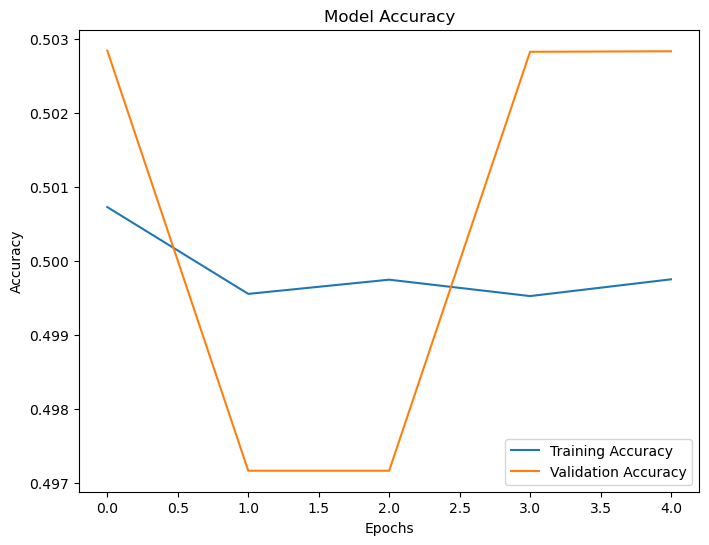

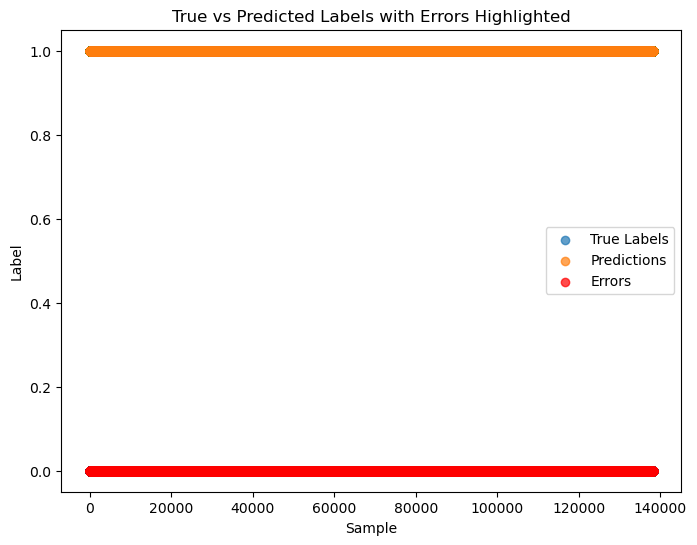

In [33]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

errors = np.where(y_test != predictions)[0]
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, label="True Labels", alpha=0.7)
plt.scatter(range(len(predictions)), predictions, label="Predictions", alpha=0.7)
plt.scatter(errors, y_test[errors], color='red', label="Errors", alpha=0.7)
plt.title("True vs Predicted Labels with Errors Highlighted")
plt.xlabel("Sample")
plt.ylabel("Label")
plt.legend()
plt.show()
